![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRjFm003pSAOtHmnUm7e--Xquwo90Hp5-U_3wSZrkChGz4tQYWZ)
# Introduction to Machine Learning
## Innopolis University 
### Week 11: Convolutional Neural Networks

Plan

1. Convolutions - application examples:
    - edge detection    
    - negation
    - blurring
    - sharpening
2. Building CNN in PyTorch
    - example CNN
    - visualizations

###Questions on comprehension

1. What is the use of convolutions? (In general)
2. Why use convolutional layers instead of fully-connected ones?



## Convolutions
Let's upload some image (you can try your own image changing the url)

In [0]:
!wget -O grid_img.jpg "https://res-2.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_256,w_256,f_auto,q_auto:eco/lss423kothpqpjpwbzg0"

--2019-10-13 10:46:09--  https://res-2.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_256,w_256,f_auto,q_auto:eco/lss423kothpqpjpwbzg0
Resolving res-2.cloudinary.com (res-2.cloudinary.com)... 104.81.140.54, 2a02:26f0:7b:183::523, 2a02:26f0:7b:191::523
Connecting to res-2.cloudinary.com (res-2.cloudinary.com)|104.81.140.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21430 (21K) [image/jpeg]
Saving to: ‘grid_img.jpg’

grid_img.jpg        100%[===================>]  20.93K  --.-KB/s    in 0s      

2019-10-13 10:46:09 (276 MB/s) - ‘grid_img.jpg’ saved [21430/21430]



In [0]:
# show what files do we have
!ls

conv1_weights.png  conv2_weights.png  grid_img.jpg  mnist_inno.pt  sample_data


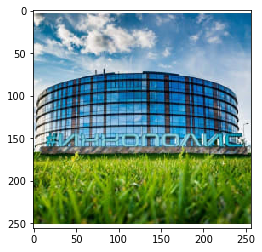

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy import ndimage

# Let's read and plot the image
image = plt.imread('grid_img.jpg')
plt.imshow(image)

original img shape:  (256, 256, 3)
grayscale img shape (256, 256)


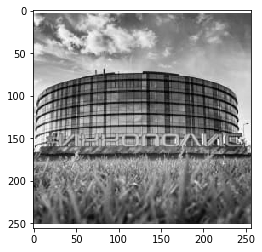

In [0]:
gray_image = rgb2gray(image)
plt.imshow(gray_image * 100, cmap='gray')
print("original img shape: ", image.shape)
print("grayscale img shape", gray_image.shape)


In [0]:
# first, define edge-detecting filters
horizontal_kernel = np.array([[1, 1, 1], 
                              [0, 0, 0], 
                              [-1, -1, -1]])
print(horizontal_kernel, 'is a kernel for detecting horizontal edges')
 
vertical_kernel = np.array([[-1, 0, 1], 
                            [-1, 0, 1], 
                            [-1, 0, 1]])
print(vertical_kernel, 'is a kernel for detecting vertical edges')

# todo delete
# out_h = ndimage.convolve(gray_image, sobel_horizontal, mode='reflect')
# out_v = ndimage.convolve(gray_image, sobel_vertical, mode='reflect')


[[ 1  1  1]
 [ 0  0  0]
 [-1 -1 -1]] is a kernel for detecting horizontal edges
[[-1  0  1]
 [-1  0  1]
 [-1  0  1]] is a kernel for detecting vertical edges


Let's apply different types of convolutions on this image. Complete the following function.

Take care of dimensions - the resuting image should be of the same size.
Hint:

![alt text](https://i.gyazo.com/5265866b07235dfa181de39913e94713.png)

Horizontal kernel applied


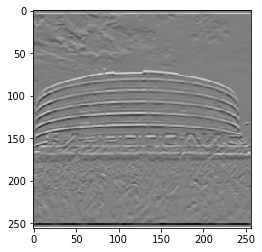

In [0]:
def convolve(img, kernel):
        w,h = img.shape[0], img.shape[1]
        f = kernel.shape[0]
        if (f - 1) % 2 !=0 :
            print("failure to choose apt padding, choose another filter size!")
        padding = (f - 1)//2
        padded_img = np.lib.pad(img, ((padding, padding), (padding, padding)), 'constant', constant_values = ((0,0),(0,0)))
        result = np.zeros(img.shape)
        for i in range(h):
            for j in range(w):
                result[i,j] = np.sum(padded_img[i:i + f, j:j+f] * kernel)                 
        return result
  
c = convolve(gray_image, horizontal_kernel)
print("Horizontal kernel applied")
plt.imshow(c, cmap='gray')

Vertical kernel applied


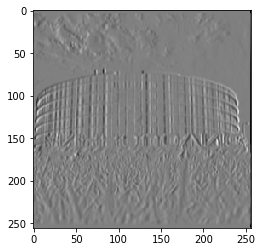

In [0]:
c = convolve(gray_image, vertical_kernel)
print("Vertical kernel applied")
plt.imshow(c, cmap='gray')

Your kernel applied


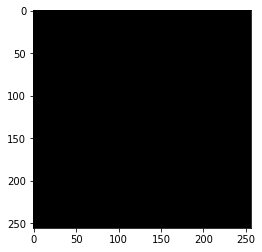

In [0]:
# play with numbers, see how changing the kernel affects the result
your_kernel = np.array([[0, 0, 0], 
                        [0, 0, 0], 
                        [0, 0, 0]])

c = convolve(gray_image, your_kernel)
print("Your kernel applied")
plt.imshow(c, cmap='gray')

some_kernel = np.array([[-1]])

Negative kernel applied


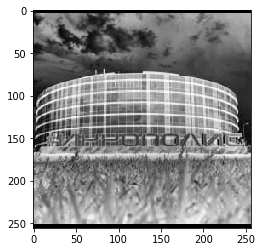

In [0]:
# Define the kernel that will result in reversed image, in which the lightest areas of
# the photographed subject appear darkest and the darkest areas appear lightest.
negative_kernel = np.array([[-1]])

c = convolve(gray_image, negative_kernel)
print("Negative kernel applied")
plt.imshow(c, cmap='gray')

Blur kernel applied


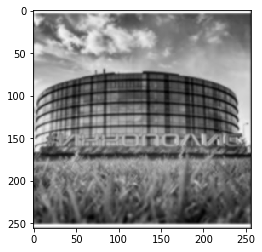

In [0]:
# Define the kernel that will result in blurred image
# How can we control the degree of blur?
v1 = 0.5
v = 0.1
# this is an example of ~ gaussian blur
blur_kernel = np.array([[v, v, v, v, v], 
                        [v, v1, v1, v1, v],
                        [v, v1, 2, v1, v],
                        [v, v1, v1, v1, v],
                        [v, v, v, v, v]])

#simple sum
blur_kernel2 = np.ones((11,11))

c_blurred = convolve(gray_image, blur_kernel)
print("Blur kernel applied")
plt.imshow(c_blurred, cmap='gray')

Negative kernel applied


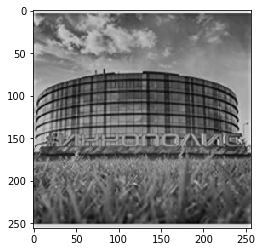

In [0]:
# Now let's sharpen the blurred image back 
sharpen_kernel = np.array([[0, -1, 0], 
                           [-1, 5, -1], 
                           [0, -1, 0]])

c = convolve(c_blurred, sharpen_kernel)
print("Sharpen kernel applied")
plt.imshow(c, cmap='gray')

## CNN with PyTorch

### 1. Data Loading

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch. utils.data import DataLoader

batch_size = 32
test_batch_size = 100

# Transformations
data_transformations = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

# Data Source
mnist_train = datasets.MNIST('../data', train=True, download=True,
                       transform=data_transformations)
mnist_test = datasets.MNIST('../data', train=False,
                            transform=data_transformations)


# Data loaders
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=test_batch_size, shuffle=True)

## 2.1 CNN model

In [0]:
class Net(nn.Module):#This defines the structure of the NN.def __init__(self):super(Net, self).__init__()
        # These are all operations that we are defining.# Unlike keras, this is not the network definition.# This is just initialization of the variables that # we are going to use in the `forward()` function.self.conv1 = nn.Conv2d(1, 10, kernel_size=5)self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
#         print("1", x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         print("2", x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         print("3", x.shape)
        x = x.view(-1, 320)
#         print("4", x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_cnn = Net().to(device)

## 2.2 Fully-conected model from the last class

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, 10)
        # reducing number of params to match that of CNN
#         self.fc1 = nn.Linear(28*28, 20)
#         self.fc2 = nn.Linear(20, 100)
#         self.fc3 = nn.Linear(100, 40)
#         self.fc4 = nn.Linear(40, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_nn = Net().to(device)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
# Let's compare the number of parameters of these models:
print("Number of params in the Fully-connected model:", count_parameters(model_nn))
print("Number of params in the CNN model:", count_parameters(model_cnn))
      

Number of params in the Fully-connected model: 543860
Number of params in the CNN model: 21840


## 3. Training and testing

In [0]:
def train( model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            
def test( model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Try changing the fully-connected model to have the same number of parameters as CNN and compare the resulting performance 

In [0]:
epochs = 10
lr = 0.01
momentum = 0.5
log_interval = 700

model = model_cnn
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


    torch.save(model.state_dict(), "mnist_inno.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321744


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.668543
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.702215

Test set: Average loss: 0.1169, Accuracy: 9634/10000 (96.34%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.634212
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.572802
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.121644

Test set: Average loss: 0.0952, Accuracy: 9701/10000 (97.01%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.332487
Train Epoch: 3 [22400/60000 (37%)]	Loss: 0.301146
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.122308

Test set: Average loss: 0.0708, Accuracy: 9768/10000 (97.68%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.158633
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.122217
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.046638

Test set: Average loss: 0.0617, Accuracy: 9806/10000 (98.06%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.280537
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.101279
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.066566

Test set: Average loss: 0.0547, Accuracy: 9830/10000 (98.30%)



##Kernel Visualizations

In [0]:
# Taken and adapted from https://www.linkedin.com/pulse/custom-function-visualizing-kernel-weights-activations-arun-das
def custom_viz(kernels, path=None, cols=None):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: TODO: Number of columns (doesn't work completely yet.)
    
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    w, h: width, height in inches"""
    def set_size(w,h, ax=None):
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]

    Tot = N*C

    # If single channel kernel with HxW size,# plot them in a row.# Else, plot image with C number of columns.
    if C>1:
        columns = C
    elif cols==None:
        columns = N
    elif cols:
        columns = cols
    rows = Tot // columns 
    rows += Tot % columns

    pos = range(1,Tot + 1)

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(rows,columns,pos[k])
            ax.imshow(img, cmap='gray')
            plt.axis('off')
            k = k+1

    set_size(10,10,ax)
    if path:
        plt.savefig(path, dpi=100)
    
    plt.show()

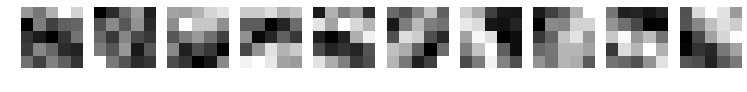

In [0]:
kernels = model.conv1.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'conv1_weights.png', 10)